#Task5 Attempt3: Changing the training Ansatz circuit and introducing some entanglements <br>



In [1]:
# import image module
from IPython.display import Image

# get the image
Image(url="QNLP_stages.drawio.png", width=900, height=500)

In [2]:
# import image module
from IPython.display import Image

# get the image
Image(url="Similarity_matrix.drawio.png", width=500, height=500)


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
import numpy as np

BATCH_SIZE = 50
EPOCHS = 120
SEED = 2

In [5]:
def read_data(filename):
    labels, sentences1, sentences2 = [], [], []
    with open(filename) as f:
        for line in f:
            split_list = line.split(",")
            t = int(split_list[2])
            labels.append(t)
            sentences1.append(split_list[0])
            sentences2.append(split_list[1])
    return labels, sentences1, sentences2

all_labels, all_sentences1, all_sentences2 = read_data('MC1.TXT')
all_data = list(zip(all_sentences1[0:80], all_sentences2[0:80]))

train_labels, train_data1, train_data2 = all_labels[0: 80], all_sentences1[0: 80], all_sentences2[0: 80]
test_labels, test_data1, test_data2 = all_labels[80: 100], all_sentences1[80: 100], all_sentences2[80: 100]
test_data =  list(zip(all_sentences1[80:100], all_sentences2[80:100]))
print(len(train_labels))


80


In [6]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text', root_cats=['S[dcl]', 'S[wq]', 'S[q]', 'S[qem]', 'NP'])

raw_train_sentences1_diagrams = parser.sentences2diagrams(train_data1)
raw_test_sentences1_diagrams = parser.sentences2diagrams(test_data1)
raw_train_sentences2_diagrams = parser.sentences2diagrams(train_data2)
raw_test_sentences2_diagrams = parser.sentences2diagrams(test_data2)


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [7]:
from lambeq import remove_cups

train_s1_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences1_diagrams]

test_s1_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences1_diagrams]

train_s2_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences2_diagrams]

test_s2_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences2_diagrams]

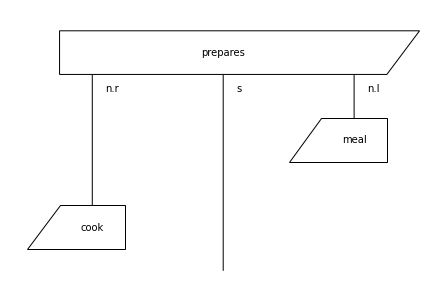

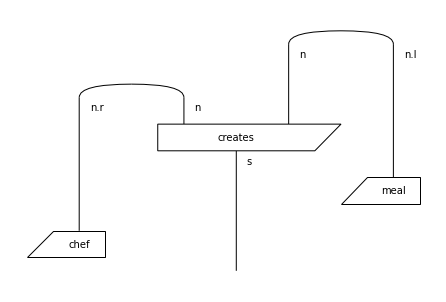

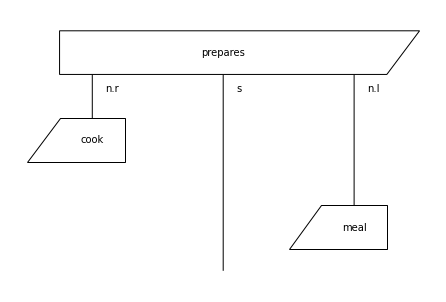

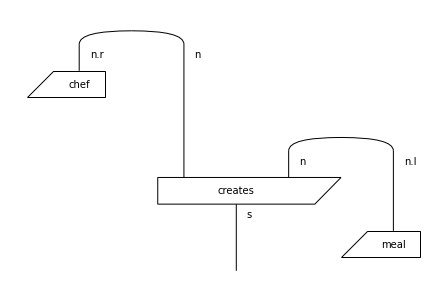

In [8]:
from lambeq import Rewriter

# Apply rewrite rule for prepositional phrases
curry_functor = Rewriter(['curry'])
curried_s1_train_diagrams = [(diagram) for diagram in train_s1_diagrams]
curried_s1_test_diagrams = [curry_functor(diagram) for diagram in test_s1_diagrams ]
curried_s2_train_diagrams = [curry_functor(diagram) for diagram in train_s2_diagrams]
curried_s2_test_diagrams = [curry_functor(diagram) for diagram in test_s2_diagrams]
curried_s1_train_diagrams[75].draw()
curried_s2_train_diagrams[75].draw()
normalised_s1_train_diagrams = [diagram.normal_form() for diagram in curried_s1_train_diagrams]
normalised_s1_test_diagrams = [diagram.normal_form() for diagram in curried_s1_test_diagrams]
normalised_s2_train_diagrams = [diagram.normal_form() for diagram in curried_s2_train_diagrams]
normalised_s2_test_diagrams = [diagram.normal_form() for diagram in curried_s2_test_diagrams]
normalised_s1_train_diagrams[75].draw()
normalised_s2_train_diagrams[75].draw()

Now looking at the above diagrams after applying the curried method, the word comlpicated was once associated with dish and once associated with code so it shall not be ambigouis anymore <br>
Let's see how our model would be happy with that <br>

In [9]:
from __future__ import annotations

__all__ = ['CircuitAnsatz', 'IQPAnsatz']

from collections.abc import Mapping
from typing import Any, Callable, Optional

from discopy.quantum.circuit import (Circuit, Discard, Functor, Id,
                                     IQPansatz as IQP, qubit)
from discopy.quantum.gates import Bra, Ket, Rx, Rz, CRx
from discopy.rigid import Box, Diagram, Ty
import numpy as np

from lambeq.ansatz import BaseAnsatz, Symbol
class CircuitAnsatz(BaseAnsatz):
    """Base class for circuit ansatz."""
    def __init__(self, ob_map: Mapping[Ty, int], **kwargs: Any) -> None:
        """Instantiate a circuit ansatz.

        Parameters
        ----------
        ob_map : dict
            A mapping from :py:class:`discopy.rigid.Ty` to the number of
            qubits it uses in a circuit.
        **kwargs : dict
            Extra parameters for ansatz configuration.

        """
        self.ob_map = ob_map
        self.functor = Functor({}, {})

    def __call__(self, diagram: Diagram) -> Circuit:
        """Convert a DisCoPy diagram into a DisCoPy circuit."""
        return self.functor(diagram)


    def _ob(self, pg_type: Ty) -> int:
        """Calculate the number of qubits used for a given type."""
        return sum(self.ob_map[Ty(factor.name)] for factor in pg_type)

    def _special_cases(self, ar_map: _ArMapT) -> _ArMapT:
        """Convert a DisCoPy box into a tket Circuit element"""
        return ar_map
class TrainAnsatz(CircuitAnsatz):
    # A new Ansatz Design to run the model training
    def __init__(self,
                 ob_map: Mapping[Ty, int],
                 n_layers: int,
                 n_single_qubit_params: int = 3,
                 discard: bool = False,
                 special_cases: Optional[Callable[[_ArMapT], _ArMapT]] = None):
        super().__init__(ob_map=ob_map, n_layers=n_layers,
                         n_single_qubit_params=n_single_qubit_params)

        if special_cases is None:
            special_cases = self._special_cases

        self.n_layers = n_layers
        self.n_single_qubit_params = n_single_qubit_params
        self.discard = discard
        self.functor = Functor(ob=self.ob_map,
                               ar=special_cases(self._ar))
        
    def _ar(self, box: Box) -> Circuit:
        label = self._summarise_box(box)
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        n_qubits = max(dom, cod)
        n_layers = self.n_layers
        n_1qubit_params = self.n_single_qubit_params

        if n_qubits == 0:
            circuit = Id()
        elif n_qubits == 1:
            syms = [Symbol(f'{label}_{i}') for i in range(n_1qubit_params)]
            rots = [Rx, Rz, CRx]
            circuit = Id(qubit)
            for i, sym in enumerate(syms):
                circuit >>= rots[i % 2](sym)
        else:
            n_params = n_layers * (n_qubits-1)
            syms = [Symbol(f'{label}_{i}') for i in range(n_params)]
            params: np.ndarray[Any, np.dtype[Any]] = np.array(syms).reshape(
                    (n_layers, n_qubits-1))
            circuit = IQP(n_qubits, params)

        if cod > dom:
            circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
        elif self.discard:
            circuit >>= Id(cod) @ Discard(dom - cod)
        else:
            circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        return circuit
    

In [10]:
from lambeq import AtomicType, IQPAnsatz

ansatz = TrainAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_s1_circuits = [ansatz(diagram) for diagram in normalised_s1_train_diagrams]

test_s1_circuits = [ansatz(diagram) for diagram in normalised_s1_test_diagrams]

train_s2_circuits = [ansatz(diagram) for diagram in normalised_s2_train_diagrams]

test_s2_circuits = [ansatz(diagram) for diagram in normalised_s2_test_diagrams]

train_circuits = train_s1_circuits + train_s2_circuits
test_circuits =  test_s1_circuits + test_s2_circuits
all_circuits_lst = train_circuits + test_circuits
all_train_data = list(zip((list(zip(train_s1_circuits, train_s2_circuits))), train_labels))
all_test_data =  list(zip(list(zip(test_s1_circuits, test_s2_circuits)), test_labels))
all_data = all_train_data + all_test_data

In [11]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = train_circuits[0].to_tk()

render_circuit_jupyter(tket_circuit)

In [12]:
from lambeq import NumpyModel, Model
def cos_sim_2d(x, y):
        norm_x = x / np.linalg.norm(x, axis=1, keepdims=True)
        norm_y = y / np.linalg.norm(y, axis=1, keepdims=True)
        return np.matmul(norm_x, norm_y.T)
class ClassificationModel(NumpyModel): 
    right_prediction = 0
    wrong_prediction = 0
    def forward(self, Mytuple):
        a = np.array(Mytuple)
        y_hat = []
        output1 = NumpyModel.get_diagram_output(self, diagrams=a[:, 0])
        output2 = NumpyModel.get_diagram_output(self, diagrams=a[:, 1])
        #output1.reshape((1, 4))
        for i in range(0, len(Mytuple)):
            result=[ idx for idx, tup in enumerate(all_data) if tup[0] == zip(a[i, 0], a[i, 1])]
            if len(result) > 0:
                truth_value.append(all_data[i][1])
        #output2.reshape((1, 4))
        similarity_matrix = cos_sim_2d(output1, output2)
        y_hat = np.diagonal(similarity_matrix)
        for i in range(0, len(result)):
            if truth_value[i] == np.round(y_hat[i]):
                self.right_prediction +=1
            else:
                self.wrong_prediction+=1
        if self.right_prediction > 0:
            print('accuracy: ', self.right_prediction / (self.right_prediction + self.wrong_prediction))
        return np.array(y_hat)


In [13]:

#Model.initialize_weights()
train_circuits2 = list(zip(train_s1_circuits , train_s2_circuits))
test_circuits2 = list(zip(test_s1_circuits , test_s2_circuits))
all_circuits = train_circuits2 + test_circuits2
sentence1_circuits= [ seq[0] for seq in all_circuits]
sentence2_circuits= [ seq[1] for seq in all_circuits]
#all_circuits = sentence1_circuits + sentence2_circuits
model = ClassificationModel.from_diagrams(all_circuits_lst, use_jit=True)


In [14]:
import numpy
epsilon=numpy.finfo('float').eps
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat + epsilon)) / len(y)  # binary cross-entropy lossةخيثم
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [15]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    epochs=EPOCHS,
    loss_function=loss,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [16]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits2,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(test_circuits2, test_labels, shuffle=False)
print(len(test_labels))

20


In [ ]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:    train/loss: 0.0443   valid/loss: 0.0338   train/acc: 0.2750   valid/acc: 0.2250
Epoch 12:   train/loss: 0.0400   valid/loss: 0.0233   train/acc: 0.2750   valid/acc: 0.2250
Epoch 24:   train/loss: 0.0362   valid/loss: 0.0182   train/acc: 0.2750   valid/acc: 0.2250
Epoch 36:   train/loss: 0.0269   valid/loss: 0.0155   train/acc: 0.2750   valid/acc: 0.2250
Epoch 48:   train/loss: 0.0250   valid/loss: 0.0144   train/acc: 0.2750   valid/acc: 0.2250
Epoch 60:   train/loss: 0.0300   valid/loss: 0.0137   train/acc: 0.2750   valid/acc: 0.2250
Epoch 72:   train/loss: 0.0232   valid/loss: 0.0137   train/acc: 0.2750   valid/acc: 0.2250
Epoch 84:   train/loss: 0.0241   valid/loss: 0.0131   train/acc: 0.2750   valid/acc: 0.2250
Epoch 96:   train/loss: 0.0201   valid/loss: 0.0122   train/acc: 0.2750   valid/acc: 0.2250


In [ ]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits2), test_labels)
print('Test accuracy:', test_acc)